**IMPORT LIBRARY**

In [1]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,LambdaCallback
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Flatten, Dense
from tensorflow.keras.models import Model

from keras.layers import Input,Dropout, Dense,GlobalAveragePooling2D
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

from tqdm import tqdm
import seaborn as sns
import numpy as np
import itertools
import datetime

import cv2
import os
import io

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip -o '/content/drive/MyDrive/Bangkit/skin2.zip'

Archive:  /content/drive/MyDrive/Bangkit/skin2.zip
   creating: skin2/
   creating: skin2/berjerawat/
  inflating: skin2/berjerawat/berjerawat (1).jpg  
  inflating: skin2/berjerawat/berjerawat (100).jpg  
  inflating: skin2/berjerawat/berjerawat (101).jpg  
  inflating: skin2/berjerawat/berjerawat (102).jpg  
  inflating: skin2/berjerawat/berjerawat (103).jpg  
  inflating: skin2/berjerawat/berjerawat (104).jpg  
  inflating: skin2/berjerawat/berjerawat (105).jpg  
  inflating: skin2/berjerawat/berjerawat (106).jpg  
  inflating: skin2/berjerawat/berjerawat (107).jpg  
  inflating: skin2/berjerawat/berjerawat (108).jpg  
  inflating: skin2/berjerawat/berjerawat (109).jpg  
  inflating: skin2/berjerawat/berjerawat (110).jpg  
  inflating: skin2/berjerawat/berjerawat (111).jpg  
  inflating: skin2/berjerawat/berjerawat (112).jpg  
  inflating: skin2/berjerawat/berjerawat (113).jpg  
  inflating: skin2/berjerawat/berjerawat (114).jpg  
  inflating: skin2/berjerawat/berjerawat (115).jpg  

**SPLITTING FOLDER**

In [4]:
!pip install split-folders

*We splitting dataset into 70% TRAIN 20% VALIDATION 10%*

In [5]:
import splitfolders

input_folder = '/content/skin2'

splitfolders.ratio(input_folder, output="/content/skin2_split",
                   seed=42, ratio=(.7, .2, .1),
                   group_prefix=None)

training_dir = '/content/skin2_split/train'
validation_dir = '/content/skin2_split/val'
testing_dir = '/content/skin2_split/test'

Copying files: 1735 files [00:00, 5255.84 files/s]


In [6]:
labels = ['berjerawat', 'berminyak', 'kering', 'normal']

x_train = []  # training images
y_train = []  # training labels
x_test = []  # testing images
y_test = []  # testing labels
x_valid = []  # validation images
y_valid = []  # validation labels

image_size = 224

# Function to check if a file is hidden
def is_hidden(filepath):
    return any(part.startswith('.') for part in filepath.split(os.sep))

# Process training data
for label in labels:
    trainPath = os.path.join(training_dir, label)
    for file in tqdm(os.listdir(trainPath)):
        if is_hidden(file):
            continue  # Skip hidden files and directories
        file_path = os.path.join(trainPath, file)
        try:
            image = cv2.imread(file_path)  # Load image
            if image is None:
                raise ValueError(f"Failed to load image {file_path}")
            image = cv2.resize(image, (image_size, image_size))  # Resize image to 224x224
            x_train.append(image)
            y_train.append(labels.index(label))
        except Exception as e:
            print(f"Warning: {e}")
            continue

# Process testing data
for label in labels:
    testPath = os.path.join(testing_dir, label)
    for file in tqdm(os.listdir(testPath)):
        if is_hidden(file):
            continue  # Skip hidden files and directories
        file_path = os.path.join(testPath, file)
        try:
            image = cv2.imread(file_path)  # Load image
            if image is None:
                raise ValueError(f"Failed to load image {file_path}")
            image = cv2.resize(image, (image_size, image_size))  # Resize image to 224x224
            x_test.append(image)
            y_test.append(labels.index(label))
        except Exception as e:
            print(f"Warning: {e}")
            continue

# Process validation data
for label in labels:
    validPath = os.path.join(validation_dir, label)
    for file in tqdm(os.listdir(validPath)):
        if is_hidden(file):
            continue  # Skip hidden files and directories
        file_path = os.path.join(validPath, file)
        try:
            image = cv2.imread(file_path)  # Load image
            if image is None:
                raise ValueError(f"Failed to load image {file_path}")
            image = cv2.resize(image, (image_size, image_size))  # Resize image to 224x224
            x_valid.append(image)
            y_valid.append(labels.index(label))
        except Exception as e:
            print(f"Warning: {e}")
            continue

# Convert lists to numpy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)
x_valid = np.array(x_valid)
y_valid = np.array(y_valid)

100%|██████████| 86/86 [00:00<00:00, 92.07it/s]


**IMAGE AUGMENTATION** <br> We devised an ImageDataGenerator and integrated image augmentation due to the limited size of our available data.

In [7]:
training_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='reflect'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

# Create generators with target size set to the original size of the images if known, e.g., (256, 256)
train_generator = training_datagen.flow_from_directory(
    training_dir,
    target_size=(224, 224),  # Adjust this to your original image size
    class_mode='categorical',
    batch_size=32,
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),  # Adjust this to your original image size
    class_mode='categorical',
    batch_size=32,
    shuffle=True
)

testing_generator = validation_datagen.flow_from_directory(
    testing_dir,
    target_size=(224, 224),  # Adjust this to your original image size
    class_mode='categorical',
    batch_size=32,
    shuffle=True
)

Found 1211 images belonging to 4 classes.
Found 346 images belonging to 4 classes.
Found 176 images belonging to 4 classes.


In [ ]:
class_indices = train_generator.class_indices
print(class_indices)
class_names = list(class_indices.keys())
print(class_names)
class_count = len(class_names)

{'berjerawat': 0, 'berminyak': 1, 'kering': 2, 'normal': 3}
['berjerawat', 'berminyak', 'kering', 'normal']


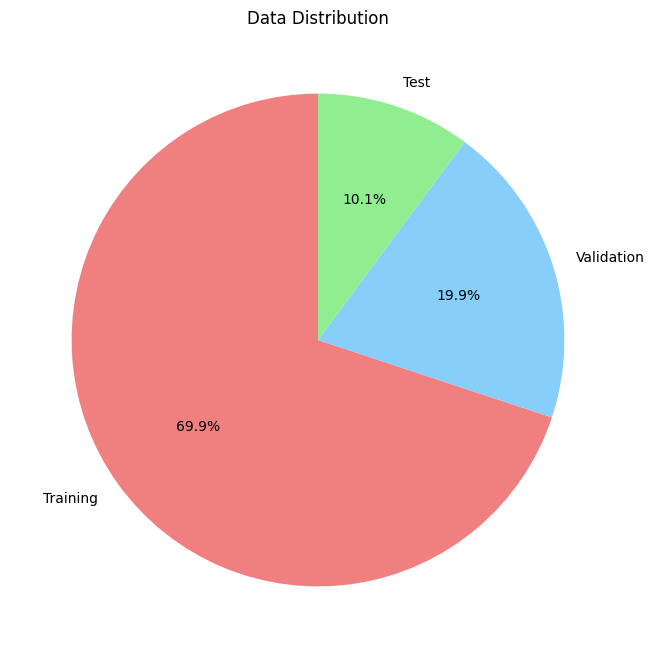

In [13]:
import matplotlib.pyplot as plt

# Menghitung jumlah data pada setiap kategori
train_size = len(x_train)
val_size = len(x_valid)
test_size = len(x_test)

# Menyiapkan data untuk pie chart
sizes = [train_size, val_size, test_size]
split = ['Training', 'Validation', 'Test']
colors = ['lightcoral', 'lightskyblue', 'lightgreen']

# Membuat pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=split, autopct='%1.1f%%', colors=colors, startangle=90)
plt.title('Data Distribution')
plt.show()

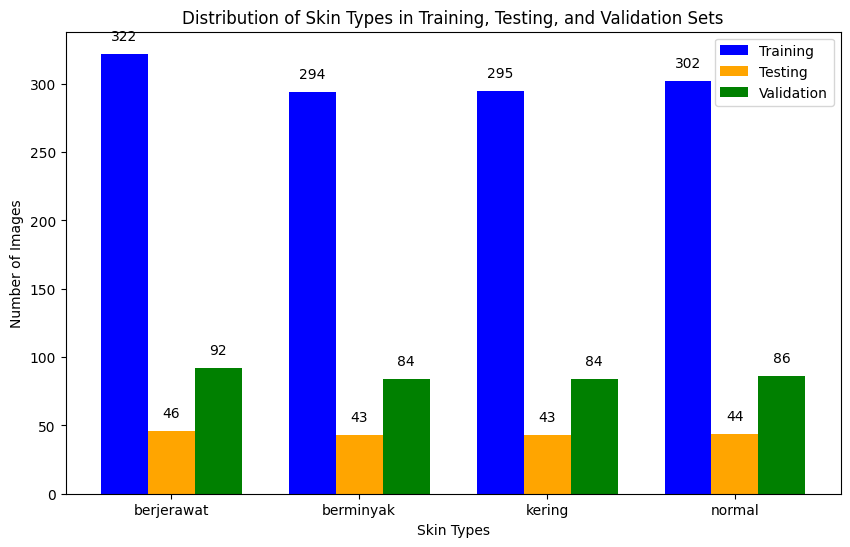

In [19]:


def plot_bar_chart(y_train, y_test, y_valid, labels):
    train_counts = np.bincount(y_train, minlength=len(labels))
    test_counts = np.bincount(y_test, minlength=len(labels))
    val_counts = np.bincount(y_valid, minlength=len(labels))

    width = 0.25
    x = np.arange(len(labels))

    fig, ax = plt.subplots(figsize=(10, 6))

    train_bars = ax.bar(x - width, train_counts, width, label='Training', color='blue')
    test_bars = ax.bar(x, test_counts, width, label='Testing', color='orange')
    val_bars = ax.bar(x + width, val_counts, width, label='Validation', color='green')

    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    plt.xlabel('Skin Types')
    plt.ylabel('Number of Images')
    plt.title('Distribution of Skin Types in Training, Testing, and Validation Sets')

    for bar, count in zip(train_bars, train_counts):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 10, str(int(count)), ha='center', color='black')

    for bar, count in zip(test_bars, test_counts):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 10, str(int(count)), ha='center', color='black')

    for bar, count in zip(val_bars, val_counts):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 10, str(int(count)), ha='center', color='black')

    plt.show()

plot_bar_chart(y_train, y_test, y_valid, labels)

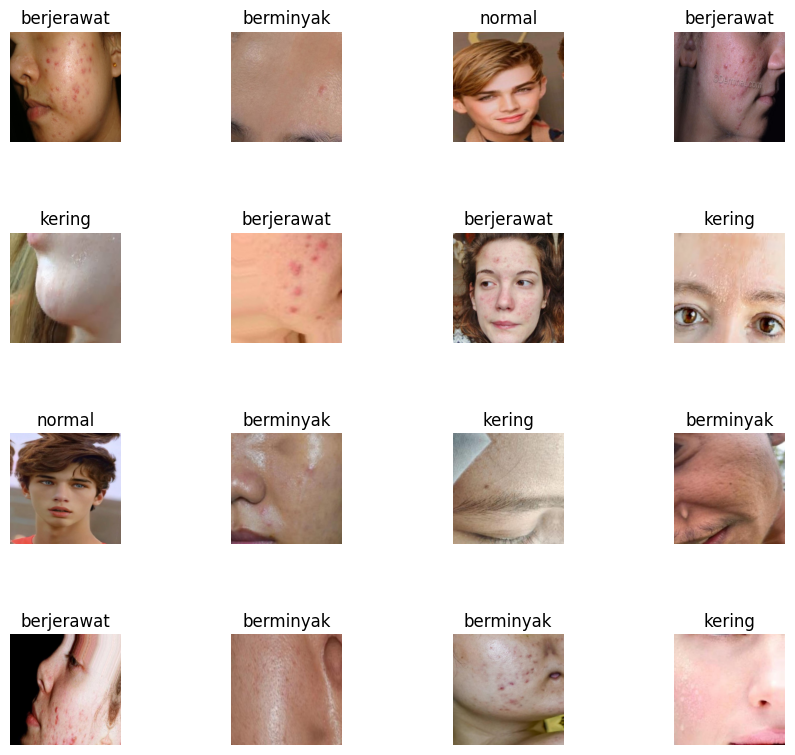

In [ ]:
def display_images(images, labels, class_indices):
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    axes = axes.ravel()

    for i, ax in enumerate(axes):
        ax.imshow(images[i])
        label_index = np.argmax(labels[i])
        label = list(class_indices.keys())[list(class_indices.values()).index(label_index)]
        ax.set_title(label)
        plt.subplots_adjust(wspace=1)
        ax.axis('off')

train_images, train_labels = next(train_generator)
display_images(train_images, train_labels, train_generator.class_indices)
plt.show()

**TRANSFER LEARNING** <br>
We utilize transfer learning with MobileNet for image classification, leveraging pre-trained knowledge to recognize and categorize images accurately.

In [ ]:
from tensorflow.keras.applications import MobileNet

In [ ]:
image_shape = (224, 224, 3)
model_name = 'MobileNet'
base_model = MobileNet(
    include_top=False,
    input_shape=image_shape,
    pooling=None,  # Remove the pooling parameter
    weights='imagenet',

)
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

17225924/17225924 [==============================] - 2s 0us/step
Number of layers in the base model:  86


In [ ]:
# Fine-tune from this layer onwards
fine_tune_at = 60

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(rate=0.3)(x)

output = Dense(4, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=output)
model.summary()

model.compile(
    Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128   

In [ ]:
rlronp_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=3, verbose=1)
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=6, verbose=1)
callbacks = [rlronp_callback, earlystop_callback]

In [ ]:
history = model.fit(train_generator,
                             epochs=100,
                             verbose=1,
                             callbacks=callbacks,
                             validation_data=validation_generator,
                             validation_steps=len(validation_generator),
                             initial_epoch=0)

Epoch 1/100
38/38 [==============================] - 33s 612ms/step - loss: 0.9965 - accuracy: 0.6590 - val_loss: 1.7557 - val_accuracy: 0.4306 - lr: 0.0010
Epoch 2/100
38/38 [==============================] - 18s 482ms/step - loss: 0.3712 - accuracy: 0.8695 - val_loss: 1.3313 - val_accuracy: 0.6763 - lr: 0.0010
Epoch 3/100
38/38 [==============================] - 20s 514ms/step - loss: 0.2615 - accuracy: 0.8993 - val_loss: 3.0314 - val_accuracy: 0.4595 - lr: 0.0010
Epoch 4/100
38/38 [==============================] - 18s 486ms/step - loss: 0.2783 - accuracy: 0.8918 - val_loss: 1.6999 - val_accuracy: 0.5925 - lr: 0.0010
Epoch 5/100
38/38 [==============================] - 20s 516ms/step - loss: 0.1639 - accuracy: 0.9397 - val_loss: 0.9388 - val_accuracy: 0.7370 - lr: 0.0010
Epoch 6/100
38/38 [==============================] - 18s 483ms/step - loss: 0.1332 - accuracy: 0.9480 - val_loss: 0.4826 - val_accuracy: 0.8555 - lr: 0.0010
Epoch 7/100
38/38 [==============================] - 18s 4

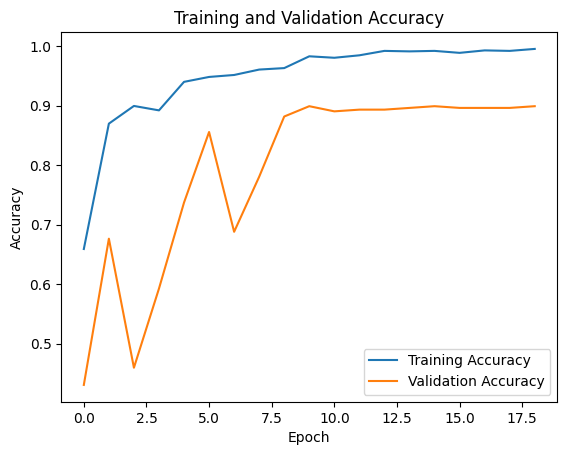

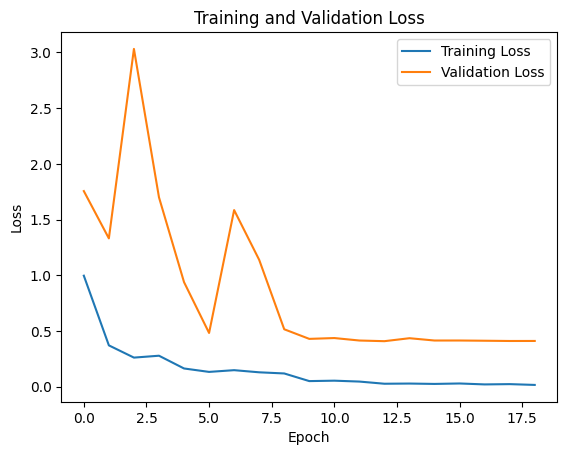

In [ ]:
# Create a plot for accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

# Create a plot for loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**TESTING** <br>
This section aims to evaluate the performance of a skin classification model that has been trained on new, never-before-seen data. This helps to determine how well the model can generalize its knowledge from training data to new data, making it reliable in real situations.

In [ ]:
test_loss, test_acc = model.evaluate(testing_generator, verbose= 2)
print(f'Test accuracy: {test_acc}')

6/6 - 1s - loss: 0.3207 - accuracy: 0.9034 - 1s/epoch - 208ms/step
Test accuracy: 0.9034090638160706


In [ ]:
model.save('final_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Found 176 images belonging to 4 classes.
176/176 [==============================] - 3s 10ms/step


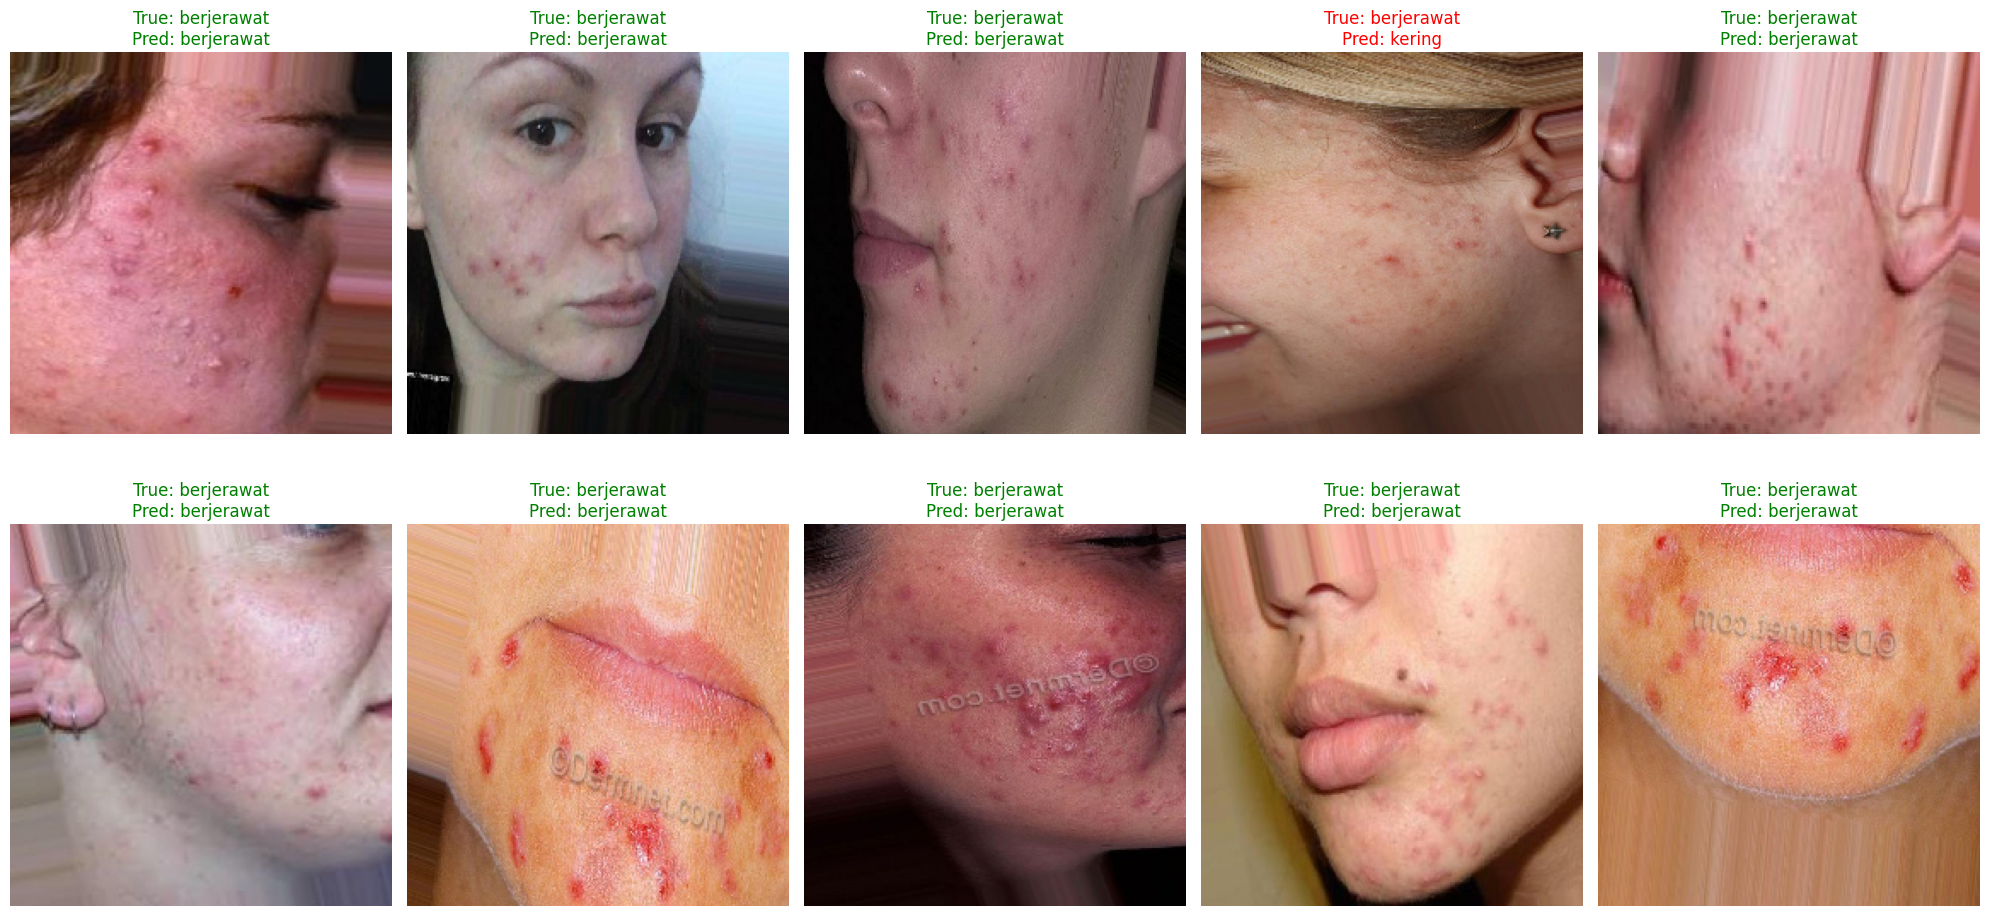

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('final_model.h5')

# Create an ImageDataGenerator for the test set
test_datagen = ImageDataGenerator(rescale=1./255)

# Define the test data generator
test_generator = test_datagen.flow_from_directory(
    testing_dir,
    target_size=(224, 224),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

# Get the class indices
class_indices = test_generator.class_indices
class_names = list(class_indices.keys())

# Predict on the test set
test_generator.reset()
predictions = model.predict(test_generator, steps=test_generator.samples, verbose=1)

# Get the predicted class indices
predicted_class_indices = np.argmax(predictions, axis=1)

# Get the true class indices
true_class_indices = test_generator.classes

# Plot the results for the first few images in the test set
num_images_to_display = 10
plt.figure(figsize=(20, 10))

for i in range(num_images_to_display):
    plt.subplot(2, 5, i + 1)
    img_path = test_generator.filepaths[i]
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0

    # Display the image
    plt.imshow(img_array)
    plt.axis('off')

    # Get the predicted and true class names
    predicted_class = class_names[predicted_class_indices[i]]
    true_class = class_names[true_class_indices[i]]

    # Set the title
    plt.title(f'True: {true_class}\nPred: {predicted_class}', color='green' if predicted_class == true_class else 'red')

plt.tight_layout()
plt.show()


The model will predict skin type (berjerawat, berminyak, kering, normal) for each uploaded image and display the prediction results along with their probabilities.

Saving IMG_3504.jpg to IMG_3504 (1).jpg
1/1 [==============================] - 1s 659ms/step


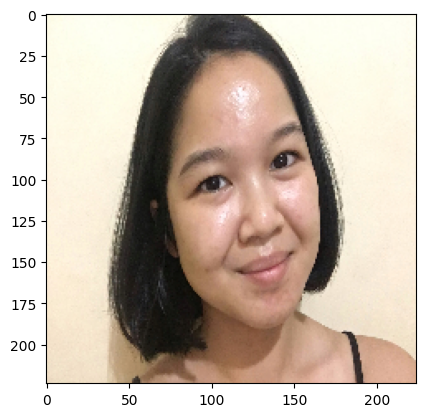

berjerawat: 0.01%
berminyak: 99.83%
kering: 0.01%
normal: 0.15%

Result:
berminyak: 99.83%


In [ ]:
from google.colab import files
from keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.models import load_model

model = load_model('final_model.h5')

labels = train_generator.class_indices.keys()
uploaded = files.upload()

for paths in uploaded.keys():
    path = paths
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    images = np.vstack([x])
    proba = model.predict(images)[0]
    maxx = proba.max()
    plt.imshow(img)
    plt.show()

    for (label, p) in zip(labels, proba):
        print("{}: {:.2f}%".format(label, p * 100))

    max_index = np.argmax(proba)
    max_proba = proba[max_index]
    max_label = list(labels)[max_index]

    if max_proba >= 0.5:
        print('\nResult:')
        print("{}: {:.2f}%".format(max_label, max_proba * 100))
    else:
        print('\nResult:')
        print('Hasil tidak ditemukan!')


In [ ]:
from google.colab import files
files.download('final_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**CONVERT TO TFLITE**

In [ ]:
import tensorflow as tf

# Load the TensorFlow model
model = tf.keras.models.load_model('/content/final_model.h5')

# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the converted model to a .tflite file
with open('converted_model.tflite', 'wb') as f:
    f.write(tflite_model)

In [ ]:
from google.colab import files
files.download('converted_model.tflite')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>